# The Battle Of Neighborhoods - Madrid

## Introduction

Madrid is the capital of Spain and the largest city of Spain. The city has a population of almost 3.3m but the metropolitan  area has approximately 6.5 million inhabitants. The municipality covers 604.3 km2 (233.3 sq mi) and its metropolitan area is the third largest in the EU, after London and Paris.

The city has 21 boroughs and 131 neighborhoods but in this project we are going to focus on the area known as "Madrid Central" and its extension to the ring inside the M-30 motorway. The meaning of "Madrid Central" is that there are traffic restrictions to this area so it is very important a good location near public transport.

## Business Problem

A foreign investor is looking to open a new restaurant in Madrid, so he has contacted me in order to help him in finding the best location for the business. On the first conversation, he asked me some questions of my knowledge of the city and I have explained that from my own experience, the offer in Madrid is huge and you can find restaurants of all types, but mainly Spanish cuisine.

After this first approach, he let me know his intentions of opening a fusion of Spanish with Mediterranean and Asian cuisine. He is looking to compete with tapas style bars but from a restaurant approach.

In order for me to complete this task, he has provided me with some guidelines of what he is looking for:
- An area where potential clients are tourists but also locals.
- The area has good transport connection: underground stations, parking.
- Busy area where the value added of his restaurant  could make an impact "borrowing" customers from restaurants around.

## Data description

The data used to approach this problem is explained as per below:
- In order to get the coordinates of Madrid, I used the data from the City Council of Madrid at their website [datos.madrid.es](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=46b55cde99be2410VgnVCM1000000b205a0aRCRD&) and with the help of Geopandas and Geocoding API from Google, I have created "coordenadas.csv" file in a different [project](https://github.com/sgarciapuga/github-coursera/blob/master/Madrid_Coordenadas_Barrios.ipynb). I also used the Geojson file for area delimitation on the map.
- I used Foursquare API to get the most common venues of Madrid Central.

## Methodology

Using the data with the coordinates of the differents neighborhoods of Madrid, we will explore them using Foursquare API.

We will use the explore function to retrive the following data:

- Most common venue categories in each neighborhood
- Most common travel and transports venues in each neighborhood
- Most common food venues in each neighborhood

We will use these features to group the neighborboods into clusters. I will use k-means clustering algorithm to complete this. I will visualize the neighborhoods in Madrid and their emergin clusters using Folium library.

### 1. Load and Explore Dataset

So, the first step is to load the libraries I will need to use in order to complete my task.

In [1]:
#libraries to manipulate data and dataframes
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#We will be using JSON files from Foursquare
import json
import requests
from pandas.io.json import json_normalize

#We will need the coordinates of Madrid, Nominatim will help with this
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from folium import plugins

print('Libraries imported.')

Libraries imported.


Firstly, we need to import our coordinates:

In [2]:
#using pandas we can create the data frame we are going to use
madrid_data = pd.read_csv("coordenadas.csv", header = 0, index_col=0)
print('Madrid dataframe loaded')

Madrid dataframe loaded


Let's take a quick look at the first few rows of the data.

In [3]:
madrid_data.head()

,borough,neighborhood,latitude,longitude
0,Villaverde,San Cristobal,40.340765,-3.688948
1,Villaverde,Butarque,40.340605,-3.674808
2,Villaverde,Los Angeles,40.354412,-3.700363
3,Villaverde,Los Rosales,40.355939,-3.691342
4,Villaverde,"Villaverde Alto, Casco Histórico de Villaverde",40.351025,-3.692555


We will rename columns to a more standard format

In [4]:
madrid_data = madrid_data.rename(columns={'borough':'Borough',
                            'neighborhood':'Neighborhood',
                            'latitude': 'Latitude',
                            'longitude':'Longitude'})

Let's check that the data is correct and has 21 boroughs and 131 neighborhoods.

In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(madrid_data['Borough'].unique()),
        madrid_data.shape[0]
    )
)

The dataframe has 21 boroughs and 131 neighborhoods.


#### Let´s get the latitude and longitude values of Madrid.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent mad_explorer, as shown below.

In [6]:
address = 'Madrid, Spain'

geolocator = Nominatim(user_agent="mad_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


#### And here we have the map of Madrid with the different neighborhoods!

We use Folium to visualize the Map of madrid with their different neighborhoods.

In [7]:
madrid_boroughs = r'madrid-districts.geojson'

def boroughs_style(feature):
    return { 'color': '#5B4D4D', "weight": 1, 'fill': False }

In [8]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(madrid_data['Latitude'],
                                           madrid_data['Longitude'],
                                           madrid_data['Borough'],
                                           madrid_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid) 
folium.GeoJson(madrid_boroughs, style_function=boroughs_style, name='geojson').add_to(map_madrid)    
map_madrid

#### Madrid Central!

We will narrow the data I am interested in all the boroughs inside the M-30 motorway.

![Madrid Central](https://upload.wikimedia.org/wikipedia/commons/7/74/Mapa_m-30.PNG#)

So, we need to drop the following boroughs and some neighborhoods (from Fuencarral and Moncloa):

- Latina
- Carabanchel
- Usera
- Villaverde
- Villa de Vallecas
- Puente de Vallecas
- Moratalaz
- Vicalvaro
- Canillejas
- San Blas
- San Blas - Canillejas
- Ciudad Lineal
- Barajas
- Hortaleza
- From Fuencarral - El Pardo:
 - Valverde
 - Mirasierra
 - Fuentelareina
 - El Goloso
 - El Pardo
- From Moncloa - Aravaca:
 - Valdemarín
 - Aravaca 
 - El Plantío 
 - Casa de Campo


In [9]:
#creting a new df dropping firstly the boroughs
madrid_central = madrid_data[~madrid_data['Borough'].isin(['Latina',
                                                           'Carabanchel',
                                                           'Usera',
                                                           'Villaverde',
                                                           'Villa de Vallecas',
                                                           'Puente de Vallecas',
                                                           'Moratalaz',
                                                           'Vicálvaro',
                                                           'Canillejas',
                                                           'Ciudad Lineal',
                                                           'Barajas',
                                                           'Hortaleza',
                                                          'San Blas',
                                                          'San Blas - Canillejas'])]

In [10]:
#Secondly, we drop those neighborhoods that are outside the M-30
madrid_central = madrid_central[~madrid_central['Neighborhood'].isin(['Valverde',
                                                                'Mirasierra',
                                                                'Fuentelareina',
                                                                'El Goloso',
                                                                'El Pardo',
                                                                'Valdemarín',
                                                                'Aravaca',
                                                                'El Plantío',
                                                                'Casa de Campo'])]

In [11]:
madrid_central = madrid_central.reset_index(drop = True)

So, let´s check how many neighborhoods we have inside the M-30

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(madrid_central['Borough'].unique()),
        madrid_central.shape[0]
    )
)

The dataframe has 9 boroughs and 49 neighborhoods.


We can see now our new map:

In [13]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(madrid_central['Latitude'],
                                           madrid_central['Longitude'],
                                           madrid_central['Borough'],
                                           madrid_central['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid) 
folium.GeoJson(madrid_boroughs, style_function=boroughs_style, name='geojson').add_to(map_madrid)     
map_madrid

#### 2. Explore Neighborhoods in Madrid Central

To explore the neighborhoods and segment them, we are going to use Foursquare API. So we need to load our credentials.

In [14]:
#for security purposes credentials are not visualized here
import config
CLIENT_ID = config.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = config.CLIENT_SECRET # your Foursquare Secret
VERSION = config.VERSION # Foursquare API version

print('Your credentails are correctly loaded')

Your credentails are correctly loaded


We will be using the below function to get the list of venues:

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=200):
    
    print("Getting the venues")
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            radius,
            limit)
   
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print(" data loaded")
    return(nearby_venues)

Now, let's get all the venues around each neighborhood

In [16]:
madrid_central_venues = getNearbyVenues(names=madrid_central['Neighborhood'],
                                        latitudes=madrid_central['Latitude'],
                                        longitudes=madrid_central['Longitude']
                                        )

Getting the venues
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . data loaded


We will use the following function to get the venues por the particular categories we are going to analysed as well.

In [17]:
def getNearbyCategory(names, latitudes, longitudes, categories, radius=500, limit=200):
    
    print("Getting the venues")
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{},&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            categories,
            radius,
            limit)
   
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print(" data loaded")
    return(nearby_venues)

You can easily find the categories using the following link from [Foursquare](https://developer.foursquare.com/docs/resources/categories).

So we are going to use the below 2 additional categories.

In [18]:
#Categories
travel = ('4d4b7105d754a06379d81259')
food = ('4d4b7105d754a06374d81259') 

Using the second function, we are retrieving all the venues for each category for our neighborhoods.

In [19]:
#return travel and transport
madrid_central_travel = (getNearbyCategory(names=madrid_central['Neighborhood'],
                                        latitudes=madrid_central['Latitude'],
                                        longitudes=madrid_central['Longitude'],
                                        categories=travel,
                                        limit=1000
                                        ))

#return food places
madrid_central_food = (getNearbyCategory(names=madrid_central['Neighborhood'],
                                        latitudes=madrid_central['Latitude'],
                                        longitudes=madrid_central['Longitude'],
                                        categories=food,
                                        limit=1000
                                        ))

Getting the venues
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . data loaded
Getting the venues
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . data loaded


#### Let's check the size of the resulting dataframes

In [20]:
print(madrid_central_venues.shape)
print(madrid_central_travel.shape)
print(madrid_central_food.shape)

(2830, 7)
(738, 7)
(2411, 7)


In [21]:
madrid_central_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Legazpi,40.391061,-3.695508,Matadero Madrid,40.392270,-3.697500,Art Gallery
1,Legazpi,40.391061,-3.695508,Central de Diseño / DIMAD,40.392015,-3.696827,Art Museum
2,Legazpi,40.391061,-3.695508,Cineteca,40.391515,-3.696521,Indie Movie Theater
3,Legazpi,40.391061,-3.695508,Nave de Música,40.391127,-3.698200,Music Venue
4,Legazpi,40.391061,-3.695508,Buenas y Santas,40.391857,-3.692877,Argentinian Restaurant


In [22]:
madrid_central_travel.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Legazpi,40.391061,-3.695508,Metro Legazpi,40.391531,-3.694788,Metro Station
1,Legazpi,40.391061,-3.695508,Mobēo,40.391404,-3.696750,Bike Rental / Bike Share
2,Legazpi,40.391061,-3.695508,Hotel Gran Legazpi Madrid,40.391786,-3.695922,Hotel
3,Legazpi,40.391061,-3.695508,Hotel Madrid Río,40.388720,-3.700306,Hotel
4,Chopera,40.394836,-3.699599,Thrifty Car Rental,40.397439,-3.695628,Rental Car Location


In [23]:
madrid_central_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Legazpi,40.391061,-3.695508,Buenas y Santas,40.391857,-3.692877,Argentinian Restaurant
1,Legazpi,40.391061,-3.695508,Cantina Matadero,40.391601,-3.696103,Argentinian Restaurant
2,Legazpi,40.391061,-3.695508,Trattoria In Crescendo,40.394582,-3.698388,Italian Restaurant
3,Legazpi,40.391061,-3.695508,Taberna Criolla,40.392056,-3.696392,BBQ Joint
4,Legazpi,40.391061,-3.695508,Dehesa de Solana,40.390124,-3.690858,Spanish Restaurant


#### Visualize venues for each neighborhood 

1. All venues

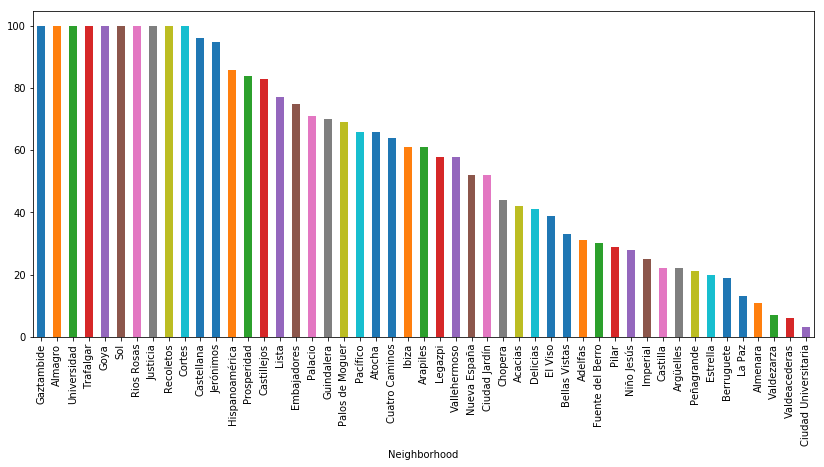

In [24]:
plt.figure(figsize=(14,6))
venues_plt = madrid_central_venues.groupby('Neighborhood').count()
venues_plt = venues_plt.sort_values(by=['Venue'], ascending=False)
venues_plt['Venue'].plot.bar()

2. Travel and Transport

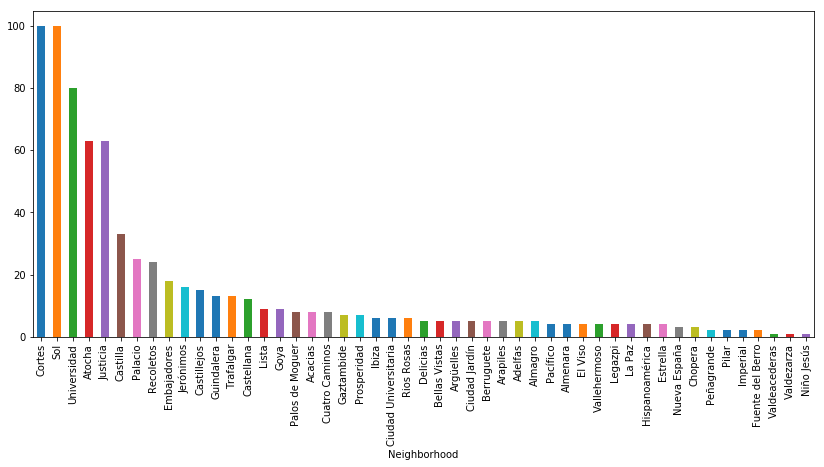

In [25]:
plt.figure(figsize=(14,6))
travel_plt = madrid_central_travel.groupby('Neighborhood').count()
travel_plt = travel_plt.sort_values(by=['Venue'], ascending=False)
travel_plt['Venue'].plot.bar()

3. Food

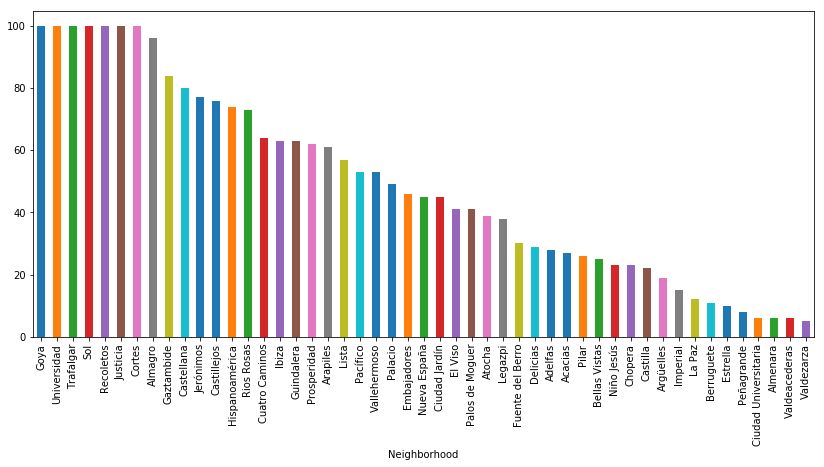

In [26]:
plt.figure(figsize=(14,6))
food_plt = madrid_central_food.groupby('Neighborhood').count()
food_plt = food_plt.sort_values(by=['Venue'], ascending=False)
food_plt['Venue'].plot.bar()

#### Let's find out how many unique categories can be curated from all the returned venues

Before we start analysing the data, lets see how many unique categories we have

In [27]:
print('There are {} uniques categories.'.format(len(madrid_central_venues['Venue Category'].unique())))
print('There are {} uniques subcategories for Travel and Transport'\
      .format(len(madrid_central_travel['Venue Category'].unique())))
print('There are {} uniques subcategories for Food'\
      .format(len(madrid_central_food['Venue Category'].unique())))

There are 243 uniques categories.
There are 22 uniques subcategories for Travel and Transport
There are 87 uniques subcategories for Food


#### 3. Analyze Each Neighborhood

In order to analyse the data, we need to convert the categorical data so we can then proceed with our data segmentation using K-means clustering.

In [28]:
# one hot encoding
madrid_central_onehot = pd.get_dummies(madrid_central_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_central_onehot['Neighborhood'] = madrid_central_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = madrid_central_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
madrid_central_onehot = madrid_central_onehot.reindex(columns= cols)

madrid_central_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Casino,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Travel Lounge,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Legazpi,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Legazpi,0,0,0,0,0,0,1,0,0,0,0,0,

In [29]:
# one hot encoding
madrid_central_travel_onehot = pd.get_dummies(madrid_central_travel[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_central_travel_onehot['Neighborhood'] = madrid_central_travel['Neighborhood'] 

# move neighborhood column to the first column
cols = madrid_central_travel_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
madrid_central_travel_onehot = madrid_central_travel_onehot.reindex(columns= cols)

madrid_central_travel_onehot.head()

,Neighborhood,Baggage Locker,Bed & Breakfast,Bike Rental / Bike Share,Boarding House,Bus Station,Bus Stop,Cable Car,Hostel,Hotel,Hotel Pool,Light Rail Station,Metro Station,Motel,Moving Target,Platform,Rental Car Location,Resort,Rest Area,Tourist Information Center,Train Station,Travel & Transport,Vacation Rental
0,Legazpi,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Legazpi,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Legazpi,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Legazpi,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chopera,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [30]:
# one hot encoding
madrid_central_food_onehot = pd.get_dummies(madrid_central_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_central_food_onehot['Neighborhood'] = madrid_central_food['Neighborhood'] 

# move neighborhood column to the first column
cols = madrid_central_food_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
madrid_central_food_onehot = madrid_central_food_onehot.reindex(columns= cols)

madrid_central_food_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Legazpi,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Legazpi,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Legazpi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Legazpi,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Legazpi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe sizes.

In [31]:
print(madrid_central_onehot.shape)
print(madrid_central_travel_onehot.shape)
print(madrid_central_food_onehot.shape)

(2830, 243)
(738, 23)
(2411, 88)


#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
#all venues
madrid_central_grouped = madrid_central_onehot.groupby('Neighborhood').mean().reset_index()
madrid_central_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Casino,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Travel Lounge,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Acacias,0.0,0.0,0.00,0.0,0.0,0.071429,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.047619,0.095238,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.000000,0.00000,0.000000,0.0,0.023810,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.000000,0.0,0.0,0.023810,0.0,0.023810,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.02381,0.000000,0.0,

In [33]:
#travel and transport
madrid_central_travel_grouped = madrid_central_travel_onehot.groupby('Neighborhood').mean().reset_index()
madrid_central_travel_grouped.head()

,Neighborhood,Baggage Locker,Bed & Breakfast,Bike Rental / Bike Share,Boarding House,Bus Station,Bus Stop,Cable Car,Hostel,Hotel,Hotel Pool,Light Rail Station,Metro Station,Motel,Moving Target,Platform,Rental Car Location,Resort,Rest Area,Tourist Information Center,Train Station,Travel & Transport,Vacation Rental
0,Acacias,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.375,0.0,0.0,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0
1,Adelfas,0.0,0.0,0.0,0.0,0.40,0.0,0.0,0.0,0.200,0.0,0.0,0.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,Almagro,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.400,0.0,0.0,0.400,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.00,0.0,0.0
3,Almenara,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.500,0.0,0.0,0.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Arapiles,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.600,0.0,0.0,0.200,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [34]:
#food
madrid_central_food_grouped = madrid_central_food_onehot.groupby('Neighborhood').mean().reset_index()
madrid_central_food_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Acacias,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.074074,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.037037,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.037037,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.148148,0.0,0.0,0.0,0.037037,0.000000,0.0,0.000000,0.000000,0.037037,0.0,0.0,0.222222,0.0,0.074074,0.0,0.148148,0.0,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0
1,Adelfas,0.0,0.000000,0.0,0.0,0.035714,0.000000,0.0,0.142857,0.000000,0.0,0.071429,0.0,0.035714,0.00000,0.0,0.107143,0.0,0.0,0.035714,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.035714,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.035714,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.071429,0.0,0.0,0.0,0.035714,0.000000,0.0,0.035714,0.000000,0.000000,0.0,0.0,0.178571,0.0,0.000000,0.0,0.071429,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Almagro,0.0,0.010417,0.0,0.0,0.010417,0.010417,0.0,0.052083,0.020833,0.0,0.010417,0.0,0.010417,0.00000,0.0,0.083333,0.0,0.0,0.010417,0.010417,0.0,0.0,0.0,0.010417,0.0,0.0,0.0,0.000000,0.010417,0.020833,0.010417,0.010417,0.0,0.020833,0.0,0.020833,0.0,0.010417,0.0,0.0,0.0,0.000000,0.0,0.0,0.052083,0.052083,0.0,0.000000,0.0,0.0,0.052083,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.010417,0.0,0.031250,0.010417,0.010417,0.0,0.0,0.197917,0.0,0.010417,0.0,0.041667,0.0,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0
3,Almenara,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.166667,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,Arapiles,0.0,0.016393,0.0,0.0,0.016393,0.000000,0.0,0.081967,0.000000,0.0,0.000000,0.0,0.016393,0.04918,0.0,0.147541,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.032787,0.0,0.0,0.0,0.000000,0.016393,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.016393,0.0,0.000000,0.0,0.

#### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in madrid_central_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = madrid_central_grouped[madrid_central_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acacias----
                venue  freq
0                 Bar  0.10
1  Spanish Restaurant  0.10
2    Tapas Restaurant  0.07
3         Art Gallery  0.07
4                Park  0.07


----Adelfas----
                venue  freq
0  Spanish Restaurant  0.10
1       Grocery Store  0.06
2                 Gym  0.06
3         Pizza Place  0.06
4                 Bar  0.06


----Almagro----
                 venue  freq
0   Spanish Restaurant  0.13
1           Restaurant  0.08
2                  Bar  0.08
3                 Café  0.05
4  Japanese Restaurant  0.04


----Almenara----
                  venue  freq
0  Gym / Fitness Center  0.18
1             BBQ Joint  0.09
2               Library  0.09
3    Spanish Restaurant  0.09
4   Japanese Restaurant  0.09


----Arapiles----
                venue  freq
0  Spanish Restaurant  0.13
1                 Bar  0.10
2          Restaurant  0.07
3              Bakery  0.07
4                Café  0.05


----Argüelles----
              venue  freq
0  Tap

                venue  freq
0  Spanish Restaurant  0.10
1    Tapas Restaurant  0.07
2               Hotel  0.07
3               Plaza  0.06
4          Restaurant  0.05


----Trafalgar----
                venue  freq
0  Spanish Restaurant  0.11
1                 Bar  0.09
2    Tapas Restaurant  0.09
3          Restaurant  0.08
4                Café  0.05


----Universidad----
                venue  freq
0               Hotel  0.07
1        Cocktail Bar  0.05
2    Tapas Restaurant  0.05
3  Spanish Restaurant  0.05
4                Café  0.04


----Valdeacederas----
                venue  freq
0  Spanish Restaurant  0.33
1                Park  0.33
2          Hobby Shop  0.17
3         Art Gallery  0.17
4              Office  0.00


----Valdezarza----
                venue  freq
0  Spanish Restaurant  0.43
1         Supermarket  0.14
2       Metro Station  0.14
3        Soccer Field  0.14
4    Asian Restaurant  0.14


----Vallehermoso----
                venue  freq
0                 Bar 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

So, I can now create a new dataframe and show the top 10 venues of each neighborhood

In [37]:
#all venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_central_grouped['Neighborhood']

for ind in np.arange(madrid_central_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_central_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacias,Bar,Spanish Restaurant,Tapas Restaurant,Art Gallery,Park,Pizza Place,Bakery,Sporting Goods Shop,Market,Sushi Restaurant
1,Adelfas,Spanish Restaurant,Pizza Place,Gym,Bar,Grocery Store,Brewery,Coffee Shop,Greek Restaurant,Gift Shop,Chinese Restaurant
2,Almagro,Spanish Restaurant,Restaurant,Bar,Café,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant,Tapas Restaurant,Bakery,Cocktail Bar
3,Almenara,Gym / Fitness Center,Hotel,Library,Coffee Shop,Restaurant,Chinese Restaurant,BBQ Joint,Flea Market,Spanish Restaurant,Japanese Restaurant
4,Arapiles,Spanish Restaurant,Bar,Restaurant,Bakery,Burrito Place,Café,Sandwich Place,Tapas Restaurant,Theater,Supermarket


In [38]:
#travel
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_travel_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_travel_sorted['Neighborhood'] = madrid_central_travel_grouped['Neighborhood']

for ind in np.arange(madrid_central_travel_grouped.shape[0]):
    neighborhoods_venues_travel_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_central_travel_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_travel_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Acacias,Metro Station,Hotel,Train Station,Vacation Rental,Hotel Pool
1,Adelfas,Bus Station,Metro Station,Hotel,Vacation Rental,Hotel Pool
2,Almagro,Metro Station,Hotel,Tourist Information Center,Vacation Rental,Hotel Pool
3,Almenara,Hotel,Bus Station,Metro Station,Vacation Rental,Hotel Pool
4,Arapiles,Hotel,Motel,Metro Station,Vacation Rental,Hotel Pool


In [39]:
#food
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_food_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_food_sorted['Neighborhood'] = madrid_central_food_grouped['Neighborhood']

for ind in np.arange(madrid_central_food_grouped.shape[0]):
    neighborhoods_venues_food_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_central_food_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_food_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacias,Spanish Restaurant,Pizza Place,Tapas Restaurant,Bakery,Sushi Restaurant,Café,Theme Restaurant,Peruvian Restaurant,Indian Restaurant,Restaurant
1,Adelfas,Spanish Restaurant,Bakery,Café,Diner,Pizza Place,Tapas Restaurant,Breakfast Spot,Falafel Restaurant,Restaurant,Sandwich Place
2,Almagro,Spanish Restaurant,Restaurant,Café,Mediterranean Restaurant,Bakery,Italian Restaurant,Japanese Restaurant,Tapas Restaurant,Sandwich Place,Gastropub
3,Almenara,Spanish Restaurant,Japanese Restaurant,Restaurant,BBQ Joint,Café,Food Stand,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
4,Arapiles,Spanish Restaurant,Café,Restaurant,Bakery,Burrito Place,Sandwich Place,Diner,Tapas Restaurant,Sushi Restaurant,Italian Restaurant


## 4. Cluster Neighborhoods

We are going to define the following functions:
- first one is for looking for the optial K for clustering
- second one we will find the clusters
- third one, we wil put everything into a map using folium

In [40]:
#we will check the optimal k for clustering
def elbowplot(data_grouped):
    Sum_of_squared_distances = []
    K = range(1,30)
    for k in K:
        madrid_central_grouped_clustering = data_grouped.drop('Neighborhood', 1)
        km = kmeans = KMeans(n_clusters=k, random_state=0)
        km = km.fit(madrid_central_grouped_clustering)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    return plt.show()

In [41]:
def clusters(group, venues, neighborhoods_data, latitude, longitude, k):
    
    """
    Function for clustering the data using K-means
    
    Parameters
    ------------
    
    group: this is the data grouped by neighborhood and type of venue
    venues: type of venue sorted by frequency
    neighborhoods_data: data with the different neighborhoods
    latitude: latitude to center the map
    longitude: longitude to center the map
    k: number of clusters
    
    """
    
    kclusters=k
   
    madrid_central_grouped_clustering = group.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_central_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]
    
    # add clustering labels
    venues.insert(0, 'Cluster Labels', kmeans.labels_)
    data_merged = neighborhoods_data
    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    data_merged = data_merged.join(venues.set_index('Neighborhood'), on='Neighborhood')
    data_merged # check the last columns!
    return data_merged

In [42]:
def clustermap(data_merged, latitude, longitude, k):
    
    kclusters=k
    
    """
    Function for creating folium map with the clusters
    
    Parameters
    ------------
    
    data_merged: data with the clusters
    latitude: latitude to center the map
    longitude: longitude to center the map
    k: number of clusters
    
    """
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.Paired(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(data_merged['Latitude'],
                                  data_merged['Longitude'],
                                  data_merged['Neighborhood'],
                                  data_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=6,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.8).add_to(map_clusters)
    
    #folium.GeoJson(madrid_boroughs, style_function=boroughs_style, name='geojson').add_to(map_clusters)        
    return map_clusters

#### Let´s start analysing all venues

Let´s check the optimal number of clusters

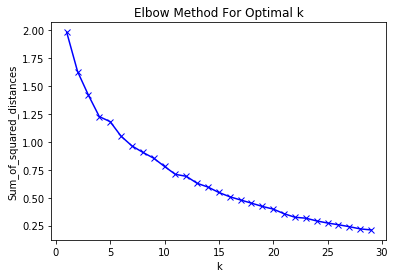

In [43]:
vanues_check = elbowplot(madrid_central_grouped)

We can see that the optimal is 11 clusters

In [44]:
venues_merged = clusters(madrid_central_grouped,
                           neighborhoods_venues_sorted,
                           madrid_central,
                           latitude,
                           longitude,
                          k=11)

In [45]:
venues_clusters = clustermap(venues_merged,
                           latitude,
                           longitude,
                           k=11)
venues_clusters

In order to examine the clusters, we are going to use the clusters that are covering mainly the central areas of madrid:
- clusters 3 (light green)
- cluster 7 (orange)
- cluster 9 (violet).

#### Cluster 3: Spanish Restaurants and Tapas, with bars and cafes.

In [46]:
venues_merged.loc[venues_merged['Cluster Labels'] == 3,
                  venues_merged.columns[[1] + list(range(5, venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Pacífico,Bar,Spanish Restaurant,Restaurant,Grocery Store,Pizza Place,Tapas Restaurant,Museum,Bakery,Brewery,Asian Restaurant
25,Almagro,Spanish Restaurant,Restaurant,Bar,Café,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant,Tapas Restaurant,Bakery,Cocktail Bar
26,Trafalgar,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Café,Plaza,Brewery,Mexican Restaurant,Bakery,Italian Restaurant
27,Arapiles,Spanish Restaurant,Bar,Restaurant,Bakery,Burrito Place,Café,Sandwich Place,Tapas Restaurant,Theater,Supermarket
28,Gaztambide,Spanish Restaurant,Bar,Café,Tapas Restaurant,Restaurant,Pizza Place,Pub,Coffee Shop,Sandwich Place,Theater
30,Rios Rosas,Spanish Restaurant,Tapas Restaurant,Bar,Café,Restaurant,Italian Restaurant,Theater,Mediterranean Restaurant,Burger Joint,Brewery
31,Vallehermoso,Bar,Spanish Restaurant,Restaurant,Café,Sandwich Place,Pizza Place,Bakery,Grocery Store,Beer Garden,Tapas Restaurant
33,Ciudad Jardín,Spanish Restaurant,Restaurant,Bar,Tapas Restaurant,Café,Bakery,Sports Bar,Spa,Burger Joint,Sandwich Place
34,Prosperidad,Bar,Spanish Restaurant,Bakery,Café,Supermarket,Restaurant,Coffee Shop,Diner,Gym,Tapas Restaurant
36,Bellas Vistas,Spanish Restaurant,Pizza Place,Bar,Fast Food Restaurant,Café,Grocery Store,Pool,Supermarket,Pub,Seafood Restaurant


#### Cluster 7: More variaty of restaurants, more expensive area

In [47]:
venues_merged.loc[venues_merged['Cluster Labels'] == 7,
                  venues_merged.columns[[1] + list(range(5, venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Niño Jesús,Spanish Restaurant,Garden,Supermarket,Mexican Restaurant,Brewery,Bar,Seafood Restaurant,Pizza Place,Sporting Goods Shop,Restaurant
15,Ibiza,Spanish Restaurant,Restaurant,Tapas Restaurant,Seafood Restaurant,Plaza,Bakery,Indian Restaurant,Gastropub,Mediterranean Restaurant,Italian Restaurant
17,Goya,Spanish Restaurant,Seafood Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Plaza,Burger Joint,Chinese Restaurant,Hotel,Bookstore
19,Recoletos,Spanish Restaurant,Restaurant,Hotel,Italian Restaurant,Clothing Store,Coffee Shop,Japanese Restaurant,Jewelry Store,Café,Furniture / Home Store
21,Fuente del Berro,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Restaurant,Bakery,Seafood Restaurant,North Indian Restaurant,Spa,Steakhouse,Grocery Store
23,Lista,Spanish Restaurant,Restaurant,Seafood Restaurant,Japanese Restaurant,Clothing Store,Hotel,Mediterranean Restaurant,Burger Joint,Steakhouse,Tapas Restaurant
24,Castellana,Spanish Restaurant,Restaurant,Japanese Restaurant,Hotel,Mediterranean Restaurant,Coffee Shop,Bar,Tapas Restaurant,Furniture / Home Store,Toy / Game Store
29,Guindalera,Spanish Restaurant,Hotel,Bar,Supermarket,Restaurant,Mediterranean Restaurant,Brewery,Seafood Restaurant,Café,Pizza Place
32,El Viso,Spanish Restaurant,Plaza,Sushi Restaurant,Burger Joint,Soccer Stadium,Tapas Restaurant,Cocktail Bar,Mediterranean Restaurant,Coffee Shop,Gourmet Shop
35,Cuatro Caminos,Spanish Restaurant,Bakery,Clothing Store,Pizza Place,Japanese Restaurant,Seafood Restaurant,Sandwich Place,Restaurant,Tapas Restaurant,Coffee Shop


#### Cluster 9: Tourist area with Hotels, museums and also Spanish Restaurants and tapas.

In [48]:
venues_merged.loc[venues_merged['Cluster Labels'] == 9,
                  venues_merged.columns[[1] + list(range(5, venues_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Atocha,Hotel,Spanish Restaurant,Restaurant,Grocery Store,Train Station,Brewery,Bookstore,Sandwich Place,Tapas Restaurant,Museum
11,Cortes,Spanish Restaurant,Hotel,Restaurant,Tapas Restaurant,Hostel,Café,Plaza,Bar,Pizza Place,Cocktail Bar
12,Sol,Spanish Restaurant,Hotel,Tapas Restaurant,Plaza,Restaurant,Bistro,Gourmet Shop,Bookstore,Hostel,Ice Cream Shop
14,Jerónimos,Spanish Restaurant,Hotel,Art Museum,Restaurant,Café,Plaza,Mediterranean Restaurant,Park,Garden,Tapas Restaurant
16,Palacio,Plaza,Mexican Restaurant,Hotel,Restaurant,Spanish Restaurant,Tapas Restaurant,Bar,Garden,French Restaurant,Mediterranean Restaurant
18,Justicia,Tapas Restaurant,Restaurant,Italian Restaurant,Bakery,Gay Bar,Cocktail Bar,Cosmetics Shop,Spanish Restaurant,Bookstore,Clothing Store
20,Universidad,Hotel,Tapas Restaurant,Spanish Restaurant,Cocktail Bar,Café,Restaurant,Coffee Shop,Theater,Bar,Bookstore
45,Castilla,Platform,Bar,Hotel,Frozen Yogurt Shop,Cafeteria,Café,Nightclub,Spanish Restaurant,Bowling Alley,Metro Station


#### Now, we can check travel and transport

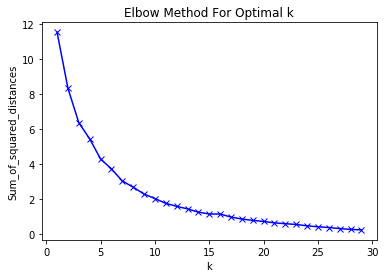

In [49]:
check = elbowplot(madrid_central_travel_grouped)

In this case, 7 seems to be the optimal

In [50]:
travel_merged = clusters(madrid_central_travel_grouped,
                           neighborhoods_venues_travel_sorted,
                           madrid_central,
                           latitude,
                           longitude,
                          k=7)

In [51]:
travel_clusters = clustermap(travel_merged,
                           latitude,
                           longitude,
                           k=7)
travel_clusters

In this map, we are clearly interested in 2 clusters:
- cluster 1(light blue)
- cluster 5(light violet)

#### Cluster 1: Transport links and hotels

In this case, we have to bear in mind that the number of venues are lower in this areas

In [52]:
travel_merged.loc[travel_merged['Cluster Labels'] == 1,
                  travel_merged.columns[[1] + list(range(5, travel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Legazpi,Hotel,Bike Rental / Bike Share,Metro Station,Vacation Rental,Hotel Pool
1,Chopera,Bike Rental / Bike Share,Rental Car Location,Hotel,Vacation Rental,Hotel Pool
2,Delicias,Hotel,Train Station,Rental Car Location,Metro Station,Vacation Rental
4,Acacias,Metro Station,Hotel,Train Station,Vacation Rental,Hotel Pool
6,Palos de Moguer,Hotel,Rental Car Location,Metro Station,Train Station,Vacation Rental
9,Embajadores,Hotel,Hostel,Metro Station,Baggage Locker,Rest Area
17,Goya,Metro Station,Hotel,Bed & Breakfast,Bus Stop,Vacation Rental
23,Lista,Hotel,Metro Station,Bed & Breakfast,Rental Car Location,Platform
25,Almagro,Metro Station,Hotel,Tourist Information Center,Vacation Rental,Hotel Pool
26,Trafalgar,Hotel,Metro Station,Bed & Breakfast,Tourist Information Center,Bus Station


#### Cluster 5: Tourist area: Hotels, bed and breakfasts and good transport links.

In [53]:
travel_merged.loc[travel_merged['Cluster Labels'] == 5,
                  travel_merged.columns[[1] + list(range(5, travel_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Cortes,Hotel,Hostel,Metro Station,Bed & Breakfast,Train Station
12,Sol,Hotel,Hostel,Bed & Breakfast,Vacation Rental,Train Station
14,Jerónimos,Hotel,Bed & Breakfast,Bike Rental / Bike Share,Bus Station,Hostel
16,Palacio,Hotel,Hostel,Resort,Moving Target,Metro Station
18,Justicia,Hotel,Hostel,Metro Station,Bike Rental / Bike Share,Bed & Breakfast
19,Recoletos,Hotel,Metro Station,Light Rail Station,Train Station,Bus Station
20,Universidad,Hotel,Hostel,Rental Car Location,Metro Station,Bed & Breakfast
22,Argüelles,Hotel,Cable Car,Metro Station,Vacation Rental,Hotel Pool
24,Castellana,Hotel,Metro Station,Bed & Breakfast,Vacation Rental,Hotel Pool
27,Arapiles,Hotel,Motel,Metro Station,Vacation Rental,Hotel Pool


#### Finally, we check food

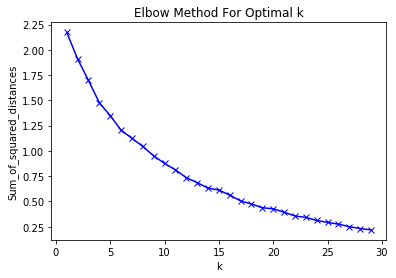

In [54]:
check = elbowplot(madrid_central_food_grouped)

It is a bit unclear, but i will use 11 again

In [55]:
food_merged = clusters(madrid_central_food_grouped,
                           neighborhoods_venues_food_sorted,
                           madrid_central,
                           latitude,
                           longitude,
                          k=11)

In [56]:
food_clusters = clustermap(food_merged,
                           latitude,
                           longitude,
                           k=11)
food_clusters

In this map, we are clearly interested in 4 clusters:
- cluster 0(brown)
- cluster 1(light blue)
- cluster 3(green)
- cluster 10(yellow)

#### Cluster 0: Middle class area with a lot of tapas restaurants

In [57]:
food_merged.loc[food_merged['Cluster Labels'] == 0,
                  food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Legazpi,Spanish Restaurant,Tapas Restaurant,Restaurant,Pizza Place,Chinese Restaurant,Café,Burger Joint,Bakery,Seafood Restaurant,Argentinian Restaurant
1,Chopera,Tapas Restaurant,Spanish Restaurant,Restaurant,Burger Joint,Mediterranean Restaurant,Café,Korean Restaurant,Pizza Place,Brazilian Restaurant,Italian Restaurant
2,Delicias,Spanish Restaurant,Tapas Restaurant,Bakery,Mediterranean Restaurant,Restaurant,Pizza Place,Sandwich Place,Burger Joint,Snack Place,Café
4,Acacias,Spanish Restaurant,Pizza Place,Tapas Restaurant,Bakery,Sushi Restaurant,Café,Theme Restaurant,Peruvian Restaurant,Indian Restaurant,Restaurant
6,Palos de Moguer,Spanish Restaurant,Tapas Restaurant,Restaurant,Café,Pizza Place,Fast Food Restaurant,Burger Joint,Bakery,Chinese Restaurant,Falafel Restaurant
9,Embajadores,Tapas Restaurant,Spanish Restaurant,Café,Indian Restaurant,Bistro,Pizza Place,Sushi Restaurant,Vegetarian / Vegan Restaurant,Creperie,Bakery
20,Universidad,Spanish Restaurant,Tapas Restaurant,Café,Argentinian Restaurant,Chinese Restaurant,Restaurant,Japanese Restaurant,Gastropub,Pizza Place,Seafood Restaurant
28,Gaztambide,Tapas Restaurant,Spanish Restaurant,Sandwich Place,Café,Pizza Place,Restaurant,Italian Restaurant,Mediterranean Restaurant,Asian Restaurant,Bakery
35,Cuatro Caminos,Spanish Restaurant,Bakery,Tapas Restaurant,Pizza Place,Burger Joint,Gastropub,Latin American Restaurant,Chinese Restaurant,Japanese Restaurant,Restaurant


##### Cluster 1: Area with lots of restaurants and cafes.

In [58]:
food_merged.loc[food_merged['Cluster Labels'] == 1,
                  food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Imperial,Spanish Restaurant,Café,Tapas Restaurant,Diner,Fast Food Restaurant,Burger Joint,Food Truck,Pizza Place,Korean Restaurant,American Restaurant
10,Niño Jesús,Spanish Restaurant,Mexican Restaurant,Pizza Place,Chinese Restaurant,Café,Restaurant,Mediterranean Restaurant,Burger Joint,Seafood Restaurant,Snack Place
11,Cortes,Spanish Restaurant,Tapas Restaurant,Restaurant,Mediterranean Restaurant,Café,Burger Joint,Deli / Bodega,Argentinian Restaurant,Mexican Restaurant,Pizza Place
12,Sol,Spanish Restaurant,Tapas Restaurant,Restaurant,Argentinian Restaurant,Burger Joint,Mexican Restaurant,Bistro,Deli / Bodega,Café,Japanese Restaurant
14,Jerónimos,Spanish Restaurant,Restaurant,Café,Tapas Restaurant,Mediterranean Restaurant,Breakfast Spot,Bistro,Gastropub,Japanese Restaurant,Creperie
15,Ibiza,Spanish Restaurant,Restaurant,Tapas Restaurant,Café,Seafood Restaurant,Italian Restaurant,Pizza Place,Gastropub,Mediterranean Restaurant,Indian Restaurant
17,Goya,Spanish Restaurant,Tapas Restaurant,Restaurant,Seafood Restaurant,Café,Japanese Restaurant,Sandwich Place,Burger Joint,Chinese Restaurant,Steakhouse
21,Fuente del Berro,Spanish Restaurant,Tapas Restaurant,Bakery,Restaurant,Steakhouse,Seafood Restaurant,Chinese Restaurant,Snack Place,Asian Restaurant,North Indian Restaurant
29,Guindalera,Spanish Restaurant,Café,Restaurant,Asian Restaurant,Indian Restaurant,Mediterranean Restaurant,Tapas Restaurant,Seafood Restaurant,Japanese Restaurant,Bakery
30,Rios Rosas,Spanish Restaurant,Tapas Restaurant,Café,Restaurant,Italian Restaurant,Mediterranean Restaurant,Pizza Place,Mexican Restaurant,Burger Joint,Snack Place


#### Cluster 3: Cafes and restaurants

In [59]:
food_merged.loc[food_merged['Cluster Labels'] == 3,
                  food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Adelfas,Spanish Restaurant,Bakery,Café,Diner,Pizza Place,Tapas Restaurant,Breakfast Spot,Falafel Restaurant,Restaurant,Sandwich Place
5,Pacífico,Spanish Restaurant,Café,Bakery,Restaurant,Diner,Pizza Place,Tapas Restaurant,Asian Restaurant,Italian Restaurant,Breakfast Spot
18,Justicia,Restaurant,Spanish Restaurant,Bakery,Tapas Restaurant,Italian Restaurant,Deli / Bodega,American Restaurant,Mediterranean Restaurant,Café,Gastropub
26,Trafalgar,Spanish Restaurant,Restaurant,Tapas Restaurant,Café,Bakery,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Japanese Restaurant,Bistro
27,Arapiles,Spanish Restaurant,Café,Restaurant,Bakery,Burrito Place,Sandwich Place,Diner,Tapas Restaurant,Sushi Restaurant,Italian Restaurant
31,Vallehermoso,Restaurant,Spanish Restaurant,Café,Bakery,Sandwich Place,Tapas Restaurant,Pizza Place,Snack Place,Gastropub,Deli / Bodega
33,Ciudad Jardín,Restaurant,Spanish Restaurant,Café,Tapas Restaurant,Bakery,Burger Joint,Pizza Place,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant
34,Prosperidad,Bakery,Spanish Restaurant,Café,Restaurant,Tapas Restaurant,Fast Food Restaurant,Pizza Place,Diner,Chinese Restaurant,Asian Restaurant
45,Castilla,Café,Spanish Restaurant,Restaurant,Sandwich Place,Burger Joint,Cafeteria,Diner,Tapas Restaurant,Salad Place,Fast Food Restaurant


#### Cluster 10: More expensive restaurants and big variety

In [60]:
food_merged.loc[food_merged['Cluster Labels'] == 10,
                  food_merged.columns[[1] + list(range(5, food_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Atocha,Spanish Restaurant,Restaurant,Café,Diner,Sandwich Place,Fast Food Restaurant,Snack Place,Tapas Restaurant,Salvadoran Restaurant,Falafel Restaurant
16,Palacio,Restaurant,Mexican Restaurant,Spanish Restaurant,Tapas Restaurant,BBQ Joint,Seafood Restaurant,Paella Restaurant,French Restaurant,Mediterranean Restaurant,Ramen Restaurant
19,Recoletos,Restaurant,Spanish Restaurant,Japanese Restaurant,Mexican Restaurant,Italian Restaurant,Café,Tapas Restaurant,Bakery,Burger Joint,American Restaurant
23,Lista,Spanish Restaurant,Restaurant,Seafood Restaurant,Tapas Restaurant,Mediterranean Restaurant,Japanese Restaurant,Mexican Restaurant,Chinese Restaurant,Burger Joint,Steakhouse
24,Castellana,Spanish Restaurant,Restaurant,Mediterranean Restaurant,Japanese Restaurant,Tapas Restaurant,Bistro,Café,Sushi Restaurant,French Restaurant,Bakery
25,Almagro,Spanish Restaurant,Restaurant,Café,Mediterranean Restaurant,Bakery,Italian Restaurant,Japanese Restaurant,Tapas Restaurant,Sandwich Place,Gastropub
37,Hispanoamérica,Spanish Restaurant,Restaurant,Tapas Restaurant,Bakery,Burger Joint,Gastropub,Diner,Café,Sandwich Place,Pizza Place
40,Nueva España,Restaurant,Spanish Restaurant,Mediterranean Restaurant,Argentinian Restaurant,Italian Restaurant,Steakhouse,Burger Joint,Café,American Restaurant,Tapas Restaurant


## 5. Results

So, the final results we can get for the above classificaions:
- Tourist area with plenty of accomodation, places to visit and eat: Sol, Cortes, Embajadores and Justicia
- Area full of bars, tapas and cafes: Almagro, Rio Rosas and Trafalgar
- Area with restaurants more expensive and also more variety: Castellana, Lista and Recoletos

## 6. Discussion

As expected, the area of Sol and Cortes, is a tourist area where you can find plenty of accomodation, places to visit but also places to eat. This could be a really good area to open the new restaurant. Many tourism but also frequented by locals.

Another area that would be really good for opening this business would be Castellana, Lista and Recoletos. This area is well known because there are plenty of shops and restaurants are usually more expensive. You can find Seafood, Japanese, Italian, Argentinian but also Spanish restaurants.

It is good to understand that Madrid is full of offices all around the area we have studied and it is very common for people working at these offices, having a lunch break from around 1 to 2 hours. It is very common that many restaurants near the offices are specialized in what is called "Menu del Dia", a 3 course menu for around 10 euros. This fact is something we need to take into consideration, as our business will not be focused on this clients but the data is probably "contaminated" of this type of restaurante, so after selecting the area of opening the new business would be very usefull to do a new evaluation taking some more particular variables.

## 7. Conclusion

Madrid is a really good city to open a restaurant for several reasons: more than 6 million people visit the city from abroad and millions coming from the rest of Spain.

Also, it is interesting because it is full of offices and many people go out after work to enjoy the night life of Madrid. Usually the weather is nice and shops are open usually until 9 or 10 pm.

It is a city where a good business idea would really make a difference and will have a lot of chances of success.